In [30]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics
import re
import sklearn
import nltk
#nltk.download('omw-1.4')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import sys 
!{sys.executable} -m pip install tensorflow-addons
import contractions
from bs4 import BeautifulSoup
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import train_test_split
import torch
#!pip install scikit-learn-intelex
from ast import literal_eval
from sklearnex import patch_sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install pyxlsb
from sklearn import metrics


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [31]:
def clean_data(tf_df, fs_df):
    df= pd.concat([tf_df, fs_df])
    df.columns = df.columns.str.lower()
    df= df[["patient age at treatment", 'total number of previous ivf cycles','total number of ivf pregnancies',
        'total number of live births - conceived through ivf', "type of infertility - female primary",
        "type of infertility - female secondary","type of infertility - male primary",
        "type of infertility - male secondary","type of infertility -couple primary",
        "type of infertility -couple secondary", "cause  of infertility - tubal disease",
        "cause of infertility - ovulatory disorder", "cause of infertility - male factor",
        "cause of infertility - patient unexplained", "cause of infertility - endometriosis",
        "cause of infertility - cervical factors", "cause of infertility - female factors",
        "cause of infertility - partner sperm concentration", "cause of infertility -  partner sperm morphology",
        "causes of infertility - partner sperm motility", "cause of infertility -  partner sperm immunological factors",
        "stimulation used", "egg source", "sperm from", "fresh cycle", "frozen cycle", "eggs thawed",
        "fresh eggs collected", "eggs mixed with partner sperm", "embryos transfered", "pgs", "pgd",
        "main reason for producing embroys storing eggs", "specific treatment type", "live birth occurrence"]]
    df.columns = df.columns.str.replace(' ', '_')
    #If the source of sperm and egg is from the same couple, i.e., Partner and Patient, then those patient records are 
    #considered, the rest are eliminated. 
    
    
    df=df[df["egg_source"] == 'Patient'] 
    df = df.drop('egg_source', axis=1)

    df=df[df["sperm_from"] == 'Partner'] 
    df = df.drop('sperm_from', axis=1)

    
    df = df[df.pgd != 1.0]
    df = df.drop('pgd', axis=1)

    df = df[df.pgs != 1.0]
    df = df.drop('pgs', axis=1)
    
    
    df=df[df["main_reason_for_producing_embroys_storing_eggs"] == 'Treatment Now '] 
    df = df.drop('main_reason_for_producing_embroys_storing_eggs', axis=1)

    
    df=df[df["specific_treatment_type"] != 'Unknown'] 
    df = df.drop('specific_treatment_type', axis=1)
    

    
    #In IVF, injectable medication containing both follicle-stimulating hormone (FSH) and luteinizing hormone (LH) is 
    #injected into females to stimulate more than one egg developing at a time45. It is described as "Stimulation Used" 
    #in the dataset; this study considers only patient records where stimulation is done.

    df=df[df["stimulation_used"] == 1] 
    df = df.drop('stimulation_used', axis=1)
    
    print((df['live_birth_occurrence'] == 1).sum())
    
    df = df.drop('cause_of_infertility_-__partner_sperm_immunological_factors', axis=1)
    df = df.drop('cause_of_infertility_-_female_factors', axis=1)
    
    
    from sklearn.preprocessing import LabelEncoder
    lab = LabelEncoder()

    df['patient_age_at_treatment'] = df['patient_age_at_treatment'].replace('-', '', regex=True).replace(' ', '', regex=True).astype(int)
    mask = df['patient_age_at_treatment'] != 999
    df = df[mask]
    df['patient_age_at_treatment'] = lab.fit_transform(df['patient_age_at_treatment'])

    df = df.fillna(0) 

    df= df.reset_index()
    df= df.drop(['index'], axis=1)
    return df


In [32]:
def balance_df(df):
    live_birth_df= df[df.live_birth_occurrence == 1]
    num_live_births= live_birth_df.shape[0]
    no_live_birth_df= df[df.live_birth_occurrence == 0]
    no_live_birth_sample_df= no_live_birth_df.sample(num_live_births)

    balanced_df= pd.concat([live_birth_df, no_live_birth_sample_df])
    return (balanced_df)



In [33]:
def datatypes_cleaning(balanced_df):
    balanced_df['total_number_of_previous_ivf_cycles']= balanced_df['total_number_of_previous_ivf_cycles'].replace(['>=5'], '5')
    balanced_df['total_number_of_ivf_pregnancies']= balanced_df['total_number_of_ivf_pregnancies'].replace(['>=5'], '5')
    balanced_df['fresh_eggs_collected']= balanced_df['fresh_eggs_collected'].replace(['> 50'], '50')
    balanced_df['eggs_mixed_with_partner_sperm']= balanced_df['eggs_mixed_with_partner_sperm'].replace(['> 50'], '50')
    balanced_df[["total_number_of_previous_ivf_cycles", "total_number_of_ivf_pregnancies", "fresh_eggs_collected", "eggs_mixed_with_partner_sperm"]] = balanced_df[["total_number_of_previous_ivf_cycles", "total_number_of_ivf_pregnancies", "fresh_eggs_collected", "eggs_mixed_with_partner_sperm"]].applymap(np.int64)
    balanced_df[["fresh_cycle", "frozen_cycle", "eggs_thawed", "embryos_transfered", "live_birth_occurrence"]] = balanced_df[["fresh_cycle", "frozen_cycle", "eggs_thawed", "embryos_transfered", "live_birth_occurrence"]].applymap(np.int64)
    balanced_df.fillna(0)
    return balanced_df

In [34]:
def train_test(dataframe):
    y= dataframe["live_birth_occurrence"]
    X= dataframe.drop(["live_birth_occurrence"], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, stratify=y)
    return X, y, X_train, X_test, y_train, y_test


In [35]:
def scale_dataframe(balanced_df):
    scaled_df = balanced_df.copy() 
    for column in scaled_df.columns: 
        scaled_df[column] = scaled_df[column]  / scaled_df[column].abs().max()
    return scaled_df    


In [36]:
def heatmap(dataframe):
    import seaborn as sns
    corr = dataframe.corr()
    matrix = np.triu(corr)
    cmap = sns.diverging_palette(170, 20, as_cmap=True, center= "light")
    # using the upper triangle matrix as mask 
    sns.set_theme(rc={'figure.figsize':(23,15)})
    vmax= 0.91
    sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap, vmin=-vmax, vmax=vmax)


# Code to run

In [37]:
imported_tf_df= pd.read_excel("ar-2010-2014-xlsb.xlsb")
imported_fs_df= pd.read_excel("ar-2015-2016-xlsb.xlsb")

tf_df= imported_tf_df
fs_df= imported_fs_df

In [51]:
df = clean_data(tf_df, fs_df)
balanced_df= balance_df(df)
cleaned_df= datatypes_cleaning(balanced_df)

76284


In [52]:
cleaned_df.isnull().any()

patient_age_at_treatment                               False
total_number_of_previous_ivf_cycles                    False
total_number_of_ivf_pregnancies                        False
total_number_of_live_births_-_conceived_through_ivf    False
type_of_infertility_-_female_primary                   False
type_of_infertility_-_female_secondary                 False
type_of_infertility_-_male_primary                     False
type_of_infertility_-_male_secondary                   False
type_of_infertility_-couple_primary                    False
type_of_infertility_-couple_secondary                  False
cause__of_infertility_-_tubal_disease                  False
cause_of_infertility_-_ovulatory_disorder              False
cause_of_infertility_-_male_factor                     False
cause_of_infertility_-_patient_unexplained             False
cause_of_infertility_-_endometriosis                   False
cause_of_infertility_-_cervical_factors                False
cause_of_infertility_-_p

In [53]:
X, y, X_train, X_test, y_train, y_test= train_test(cleaned_df)

X=scale_dataframe(X)
X_train=scale_dataframe(X_train)
X_test=scale_dataframe(X_test)


In [54]:
X_test.isnull().any()

patient_age_at_treatment                               False
total_number_of_previous_ivf_cycles                    False
total_number_of_ivf_pregnancies                        False
total_number_of_live_births_-_conceived_through_ivf    False
type_of_infertility_-_female_primary                   False
type_of_infertility_-_female_secondary                 False
type_of_infertility_-_male_primary                     False
type_of_infertility_-_male_secondary                   False
type_of_infertility_-couple_primary                    False
type_of_infertility_-couple_secondary                  False
cause__of_infertility_-_tubal_disease                  False
cause_of_infertility_-_ovulatory_disorder              False
cause_of_infertility_-_male_factor                     False
cause_of_infertility_-_patient_unexplained             False
cause_of_infertility_-_endometriosis                   False
cause_of_infertility_-_cervical_factors                False
cause_of_infertility_-_p

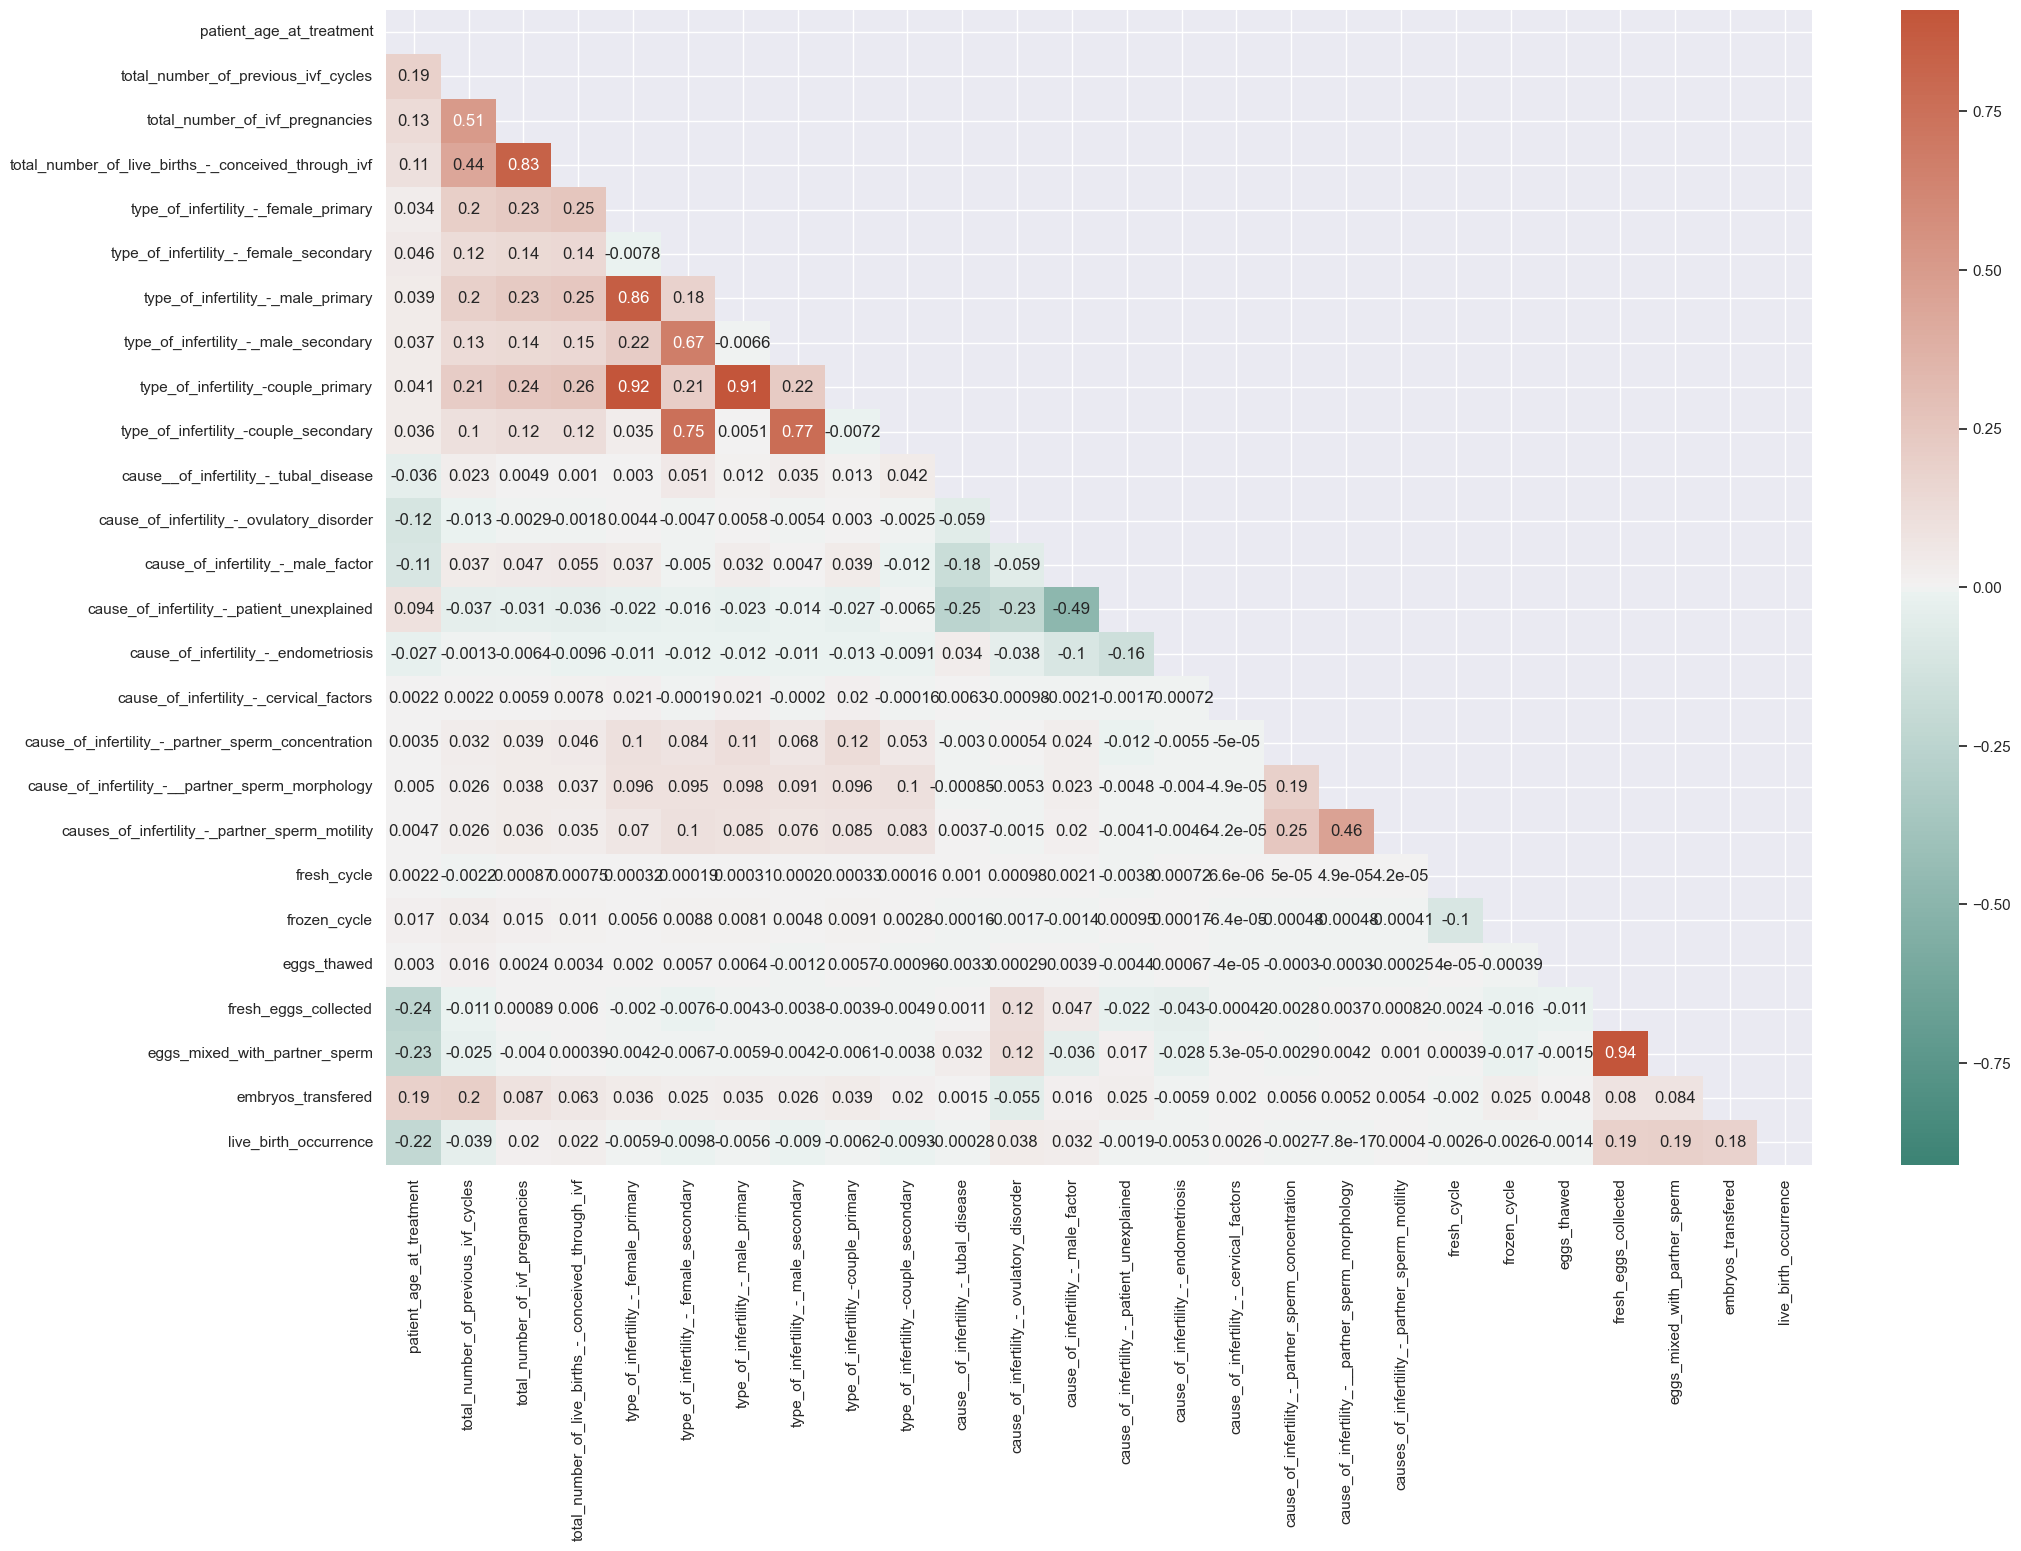

In [40]:
heatmap(cleaned_df)

In [41]:
classifiers_df= pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1','AUC'])

In [42]:
roc_df= pd.DataFrame(columns=['Classifier', 'fpr', 'tpr', 'auc'])

In [43]:
print(X_test)

        patient_age_at_treatment  total_number_of_previous_ivf_cycles  \
187489                       0.4                                  0.0   
201111                       1.0                                  0.0   
178626                       0.2                                  0.4   
253752                       0.4                                  0.2   
26170                        0.2                                  0.6   
...                          ...                                  ...   
37667                        0.2                                  0.4   
231283                       0.4                                  0.2   
21553                        0.0                                  0.0   
205676                       0.2                                  0.8   
257905                       0.0                                  0.0   

        total_number_of_ivf_pregnancies  \
187489                              0.0   
201111                              0

# Random Forest 

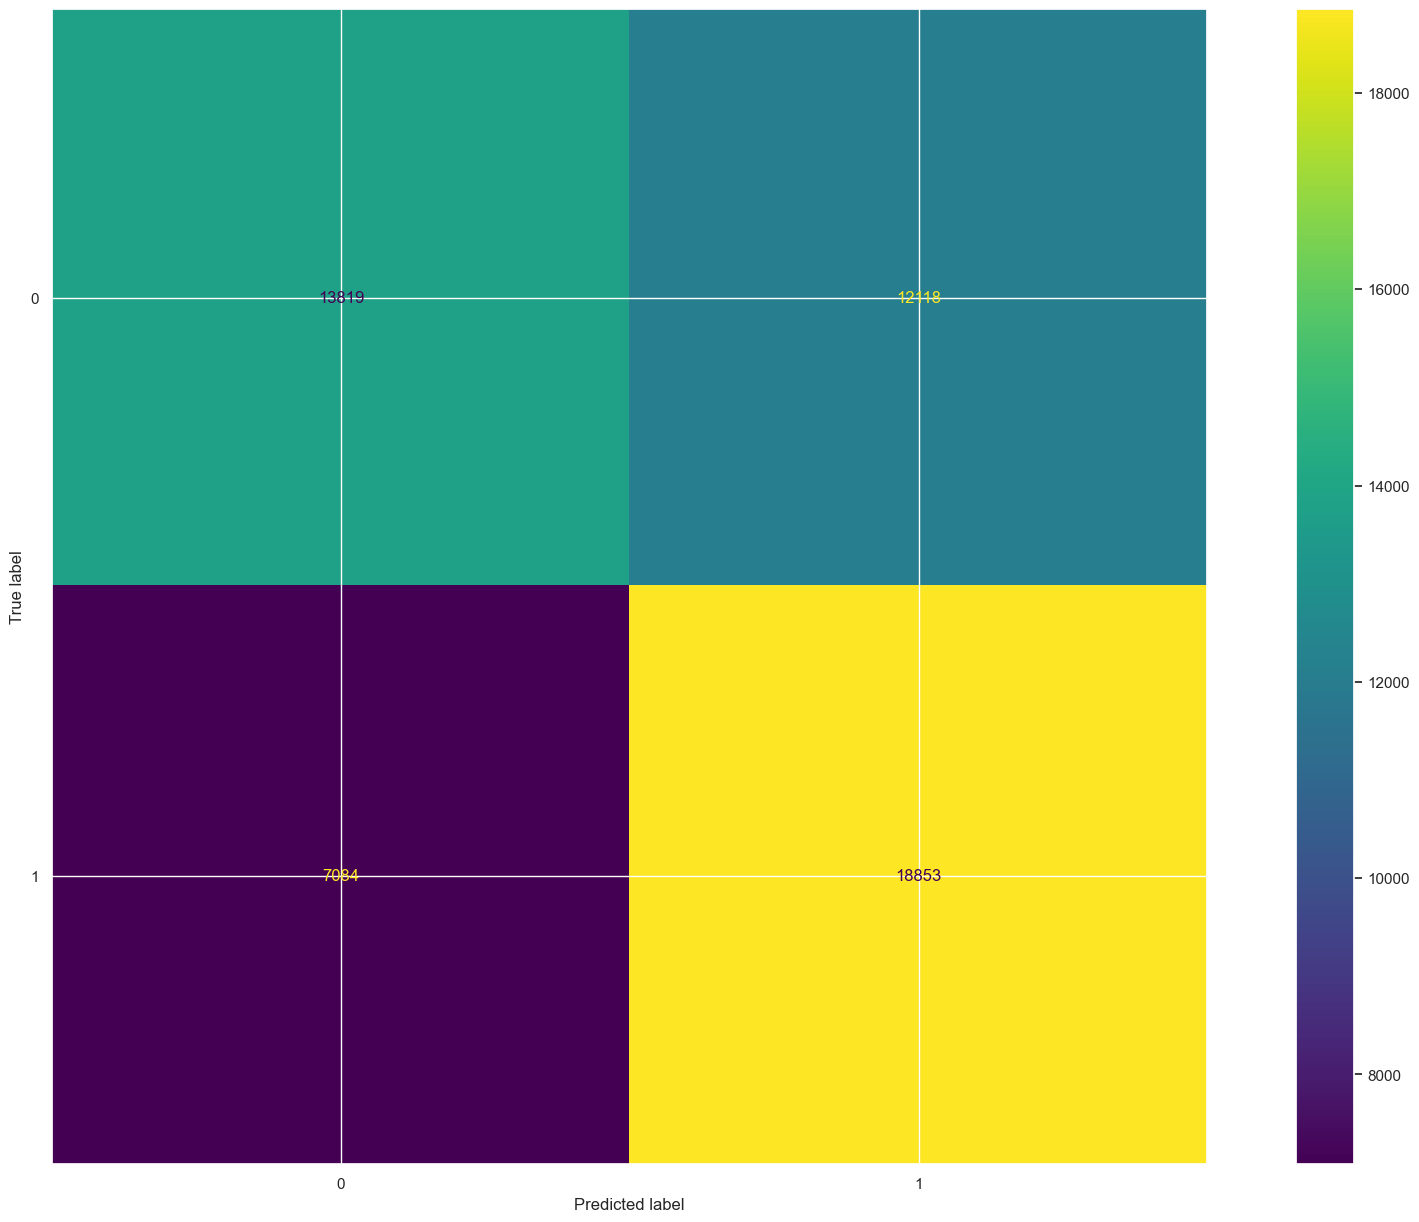

0.6298338281219878

In [55]:
first_rf_model = RandomForestClassifier(n_estimators=500)
first_rf_model.fit(X_train, y_train)

y_pred = first_rf_model.predict(X_test)
confusion_matrix(y_test, y_pred)
confusion= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.show()
accuracy_score(y_test, y_pred)

In [56]:
y_pred_proba = first_rf_model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)


0.6729994728374376


In [57]:
importances= first_rf_model.feature_importances_
columns= X.columns
i=0

while i < len(columns):
    print({columns[i]})
    print({importances[i]})
    i=i+1

{'patient_age_at_treatment'}
{0.10428425350848683}
{'total_number_of_previous_ivf_cycles'}
{0.09590921500347392}
{'total_number_of_ivf_pregnancies'}
{0.017170755593472364}
{'total_number_of_live_births_-_conceived_through_ivf'}
{0.009796261159579298}
{'type_of_infertility_-_female_primary'}
{0.0023309312263539196}
{'type_of_infertility_-_female_secondary'}
{0.0014777052237186549}
{'type_of_infertility_-_male_primary'}
{0.0022459716781503946}
{'type_of_infertility_-_male_secondary'}
{0.0015816014283594785}
{'type_of_infertility_-couple_primary'}
{0.002330913200679907}
{'type_of_infertility_-couple_secondary'}
{0.0010038924926327037}
{'cause__of_infertility_-_tubal_disease'}
{0.021129392391451517}
{'cause_of_infertility_-_ovulatory_disorder'}
{0.014781774595327002}
{'cause_of_infertility_-_male_factor'}
{0.022224380698622877}
{'cause_of_infertility_-_patient_unexplained'}
{0.019525814020257153}
{'cause_of_infertility_-_endometriosis'}
{0.01718357907847337}
{'cause_of_infertility_-_cervic

In [64]:

# Number of trees in random forest
#generally the more, the better
n_estimators = [2000]


# Number of features to consider at every split
#can be an integer, a fraction of the number of features, the square root of num features, or log2 features
max_features = [1]


# Maximum number of levels in tree
#too shallow and we miss details. Too much is overfitting
max_depth = [15,17,19,21,23,25]
max_depth.append(None)


# Minimum number of samples required to split a node
#too small can be overfitting, too large is less accurate 
min_samples_split = [2,4,8]


# Minimum number of samples required at each leaf node
#too small can be overfitting, too large is less accurate 
min_samples_leaf = [2,4,8]


# Method of selecting samples for training each tree
bootstrap = [False]
#[True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [2000], 'max_features': [1], 'max_depth': [15, 17, 19, 21, 23, 25, None], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [2, 4, 8], 'bootstrap': [False]}


In [ ]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

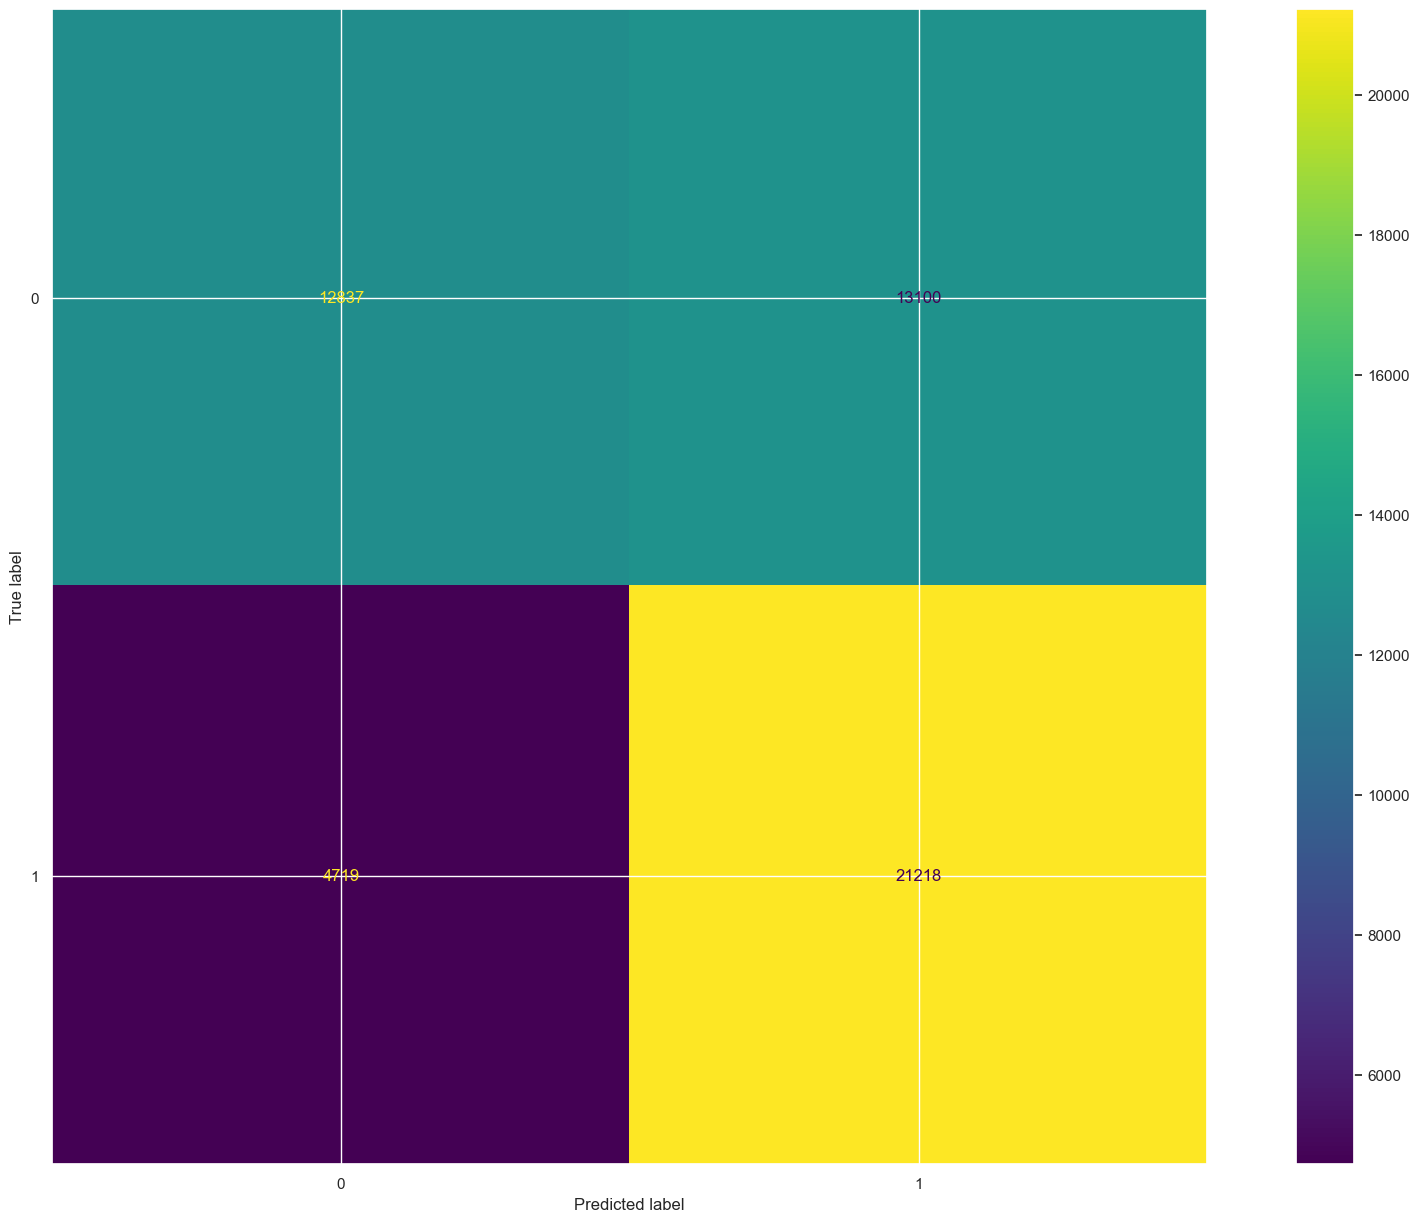

0.6564945830281066

In [62]:
best_rf_model = RandomForestClassifier(n_estimators= 500, min_samples_split= 2, min_samples_leaf= 2, max_features= 1, max_depth= 23, bootstrap= False)
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)
confusion_matrix(y_test, y_pred)
confusion= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.show()

accuracy_score(y_test, y_pred)


In [63]:
y_pred_proba = best_rf_model.predict_proba(X_test)[::,1]

rf_accuracy = accuracy_score(y_test, y_pred)
rf_f1= f1_score(y_test, y_pred, average="macro")
rf_precision= precision_score(y_test, y_pred, average="macro")
rf_recall= recall_score(y_test, y_pred, average="macro")
rf_auc = metrics.roc_auc_score(y_test, y_pred_proba)

print(rf_auc)

0.7034099625787968


In [103]:
classifiers_df.loc[len(classifiers_df.index)] = ["Random Forest", rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc]



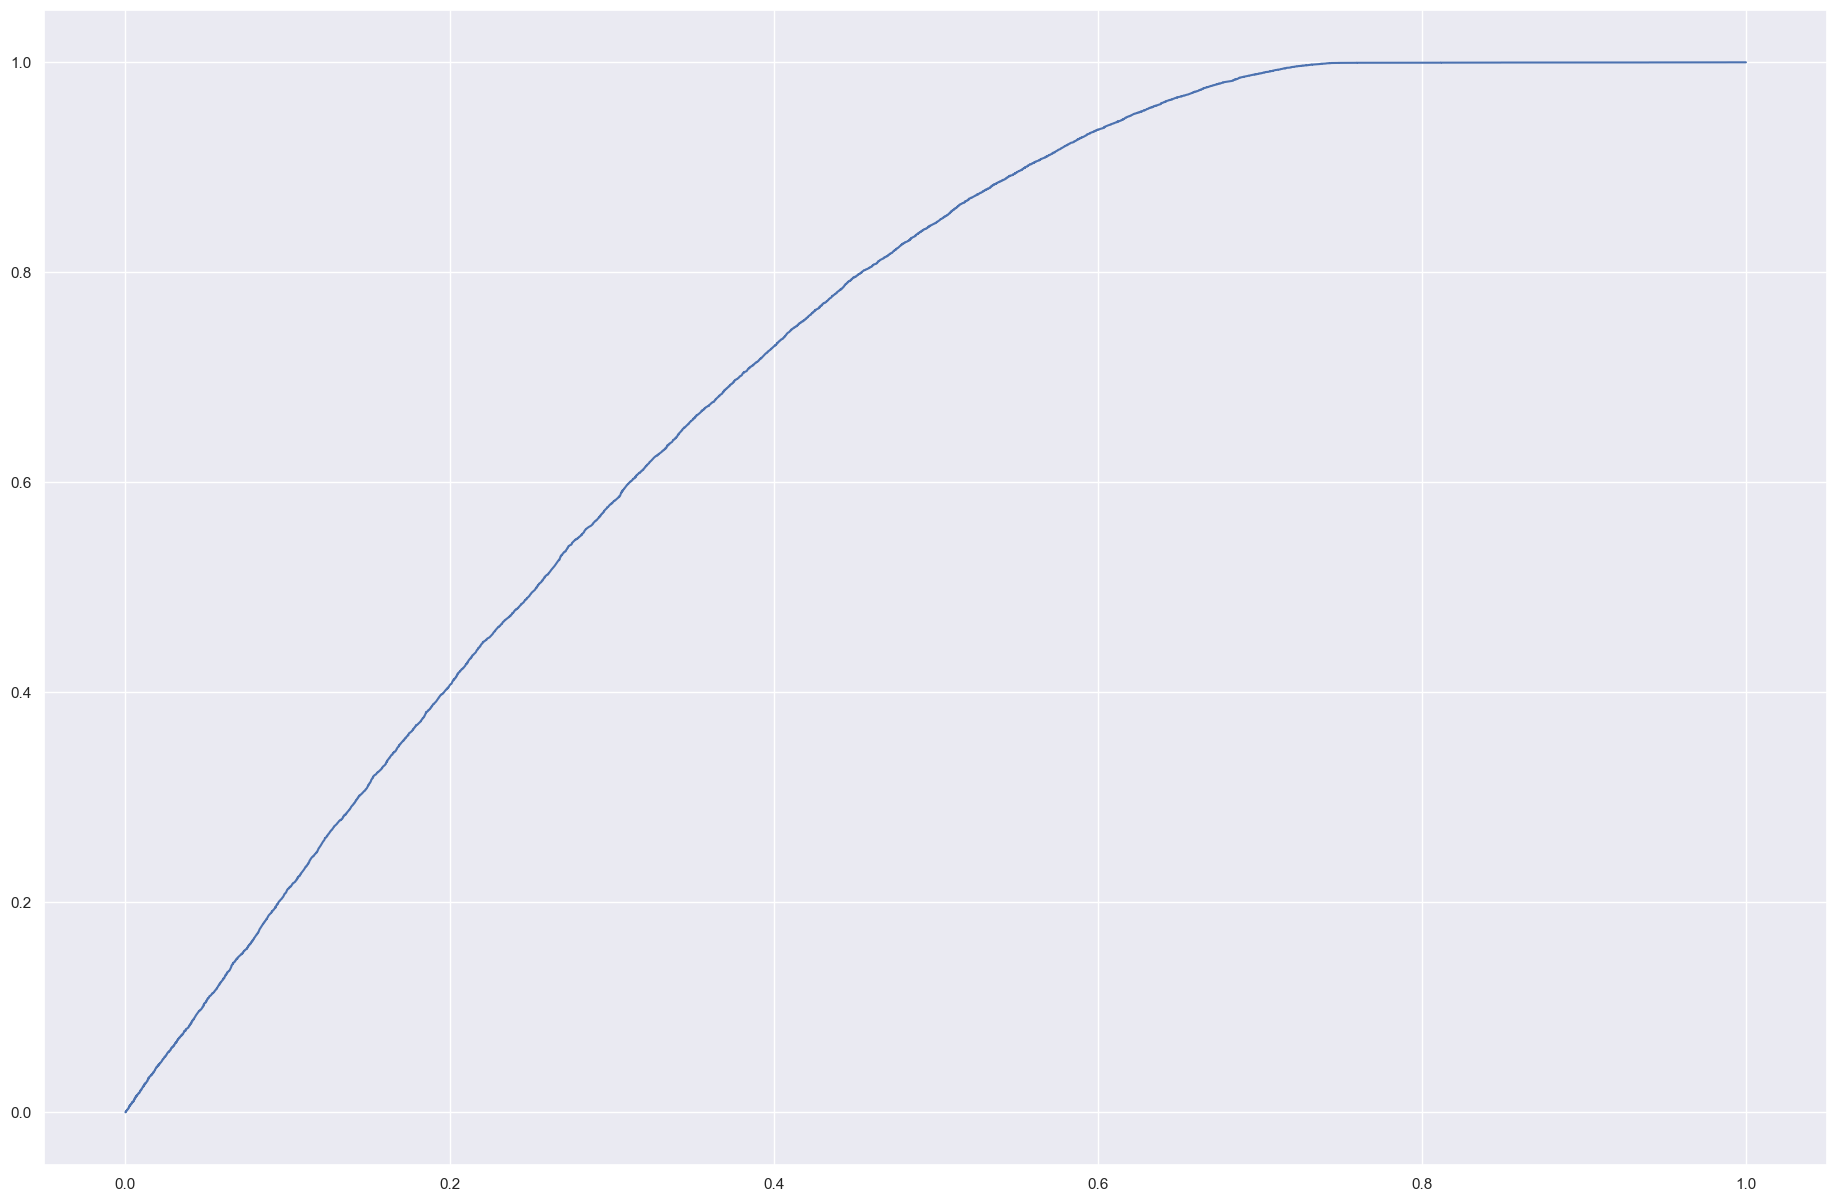

In [104]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))




In [105]:
roc_df.loc[len(roc_df.index)] = ["Random Forest", fpr, tpr, auc]

In [106]:
display(classifiers_df)
display(roc_df)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896


,Classifier,fpr,tpr,auc
0,Random Forest,"[0.0, 0.0, 0.0, 3.7334328915437745e-05, 3.7334...","[0.0, 3.7334328915437745e-05, 0.00011200298674...",0.7219


Deep Learning (Neural Network)

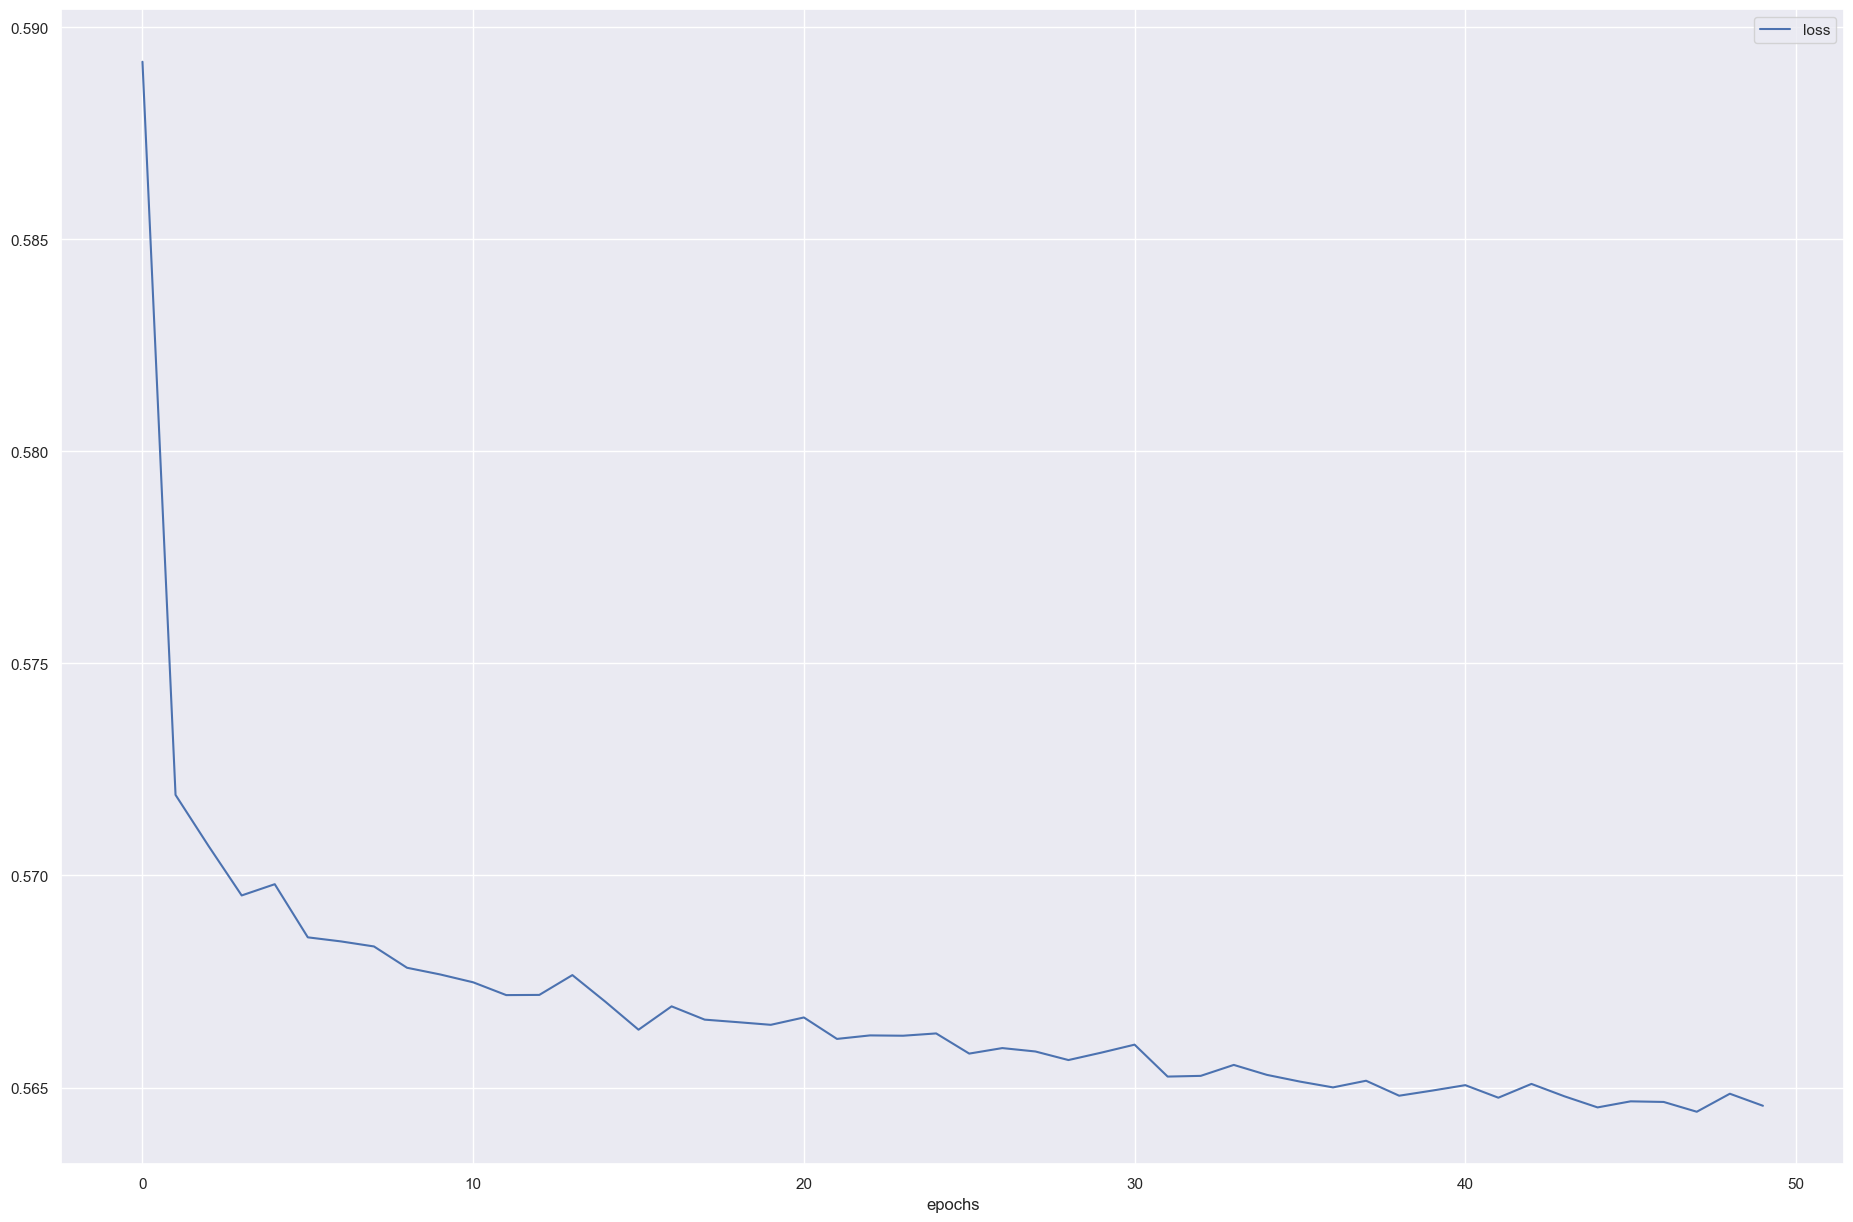

1655/1655 [==============================] - 8s 5ms/step


,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Deep Learning Neural Network,0.679850,0.624977,0.899411,0.737491,0.732040
1,Deep Learning Neural Network,0.620546,0.505693,0.998187,0.671298,0.620546


,Classifier,fpr,tpr,auc
0,Deep Learning Neural Network,"[0.0, 0.0, 0.00011332300834812829, 0.000113323...","[0.0, 3.7772909269471935e-05, 3.77729092694719...",0.7321
1,Deep Learning Neural Network,"[0.0, 3.777433611604276e-05, 0.000151097344464...","[0.0, 0.0, 0.0, 0.0, 3.7772909269471935e-05, 3...",0.6243


In [66]:
def neural_network(X_train, X_test, y_train, y_test):
    import keras
    nn_model = tf.keras.Sequential([
   
      # Flatten Layer that converts images to 1D array
      tf.keras.layers.Flatten(),
   
      # Hidden Layer with 512 units and relu activation
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(units=512, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),

      tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    #run the model
    nn_model.compile(
      loss = 'binary_crossentropy',
      optimizer = 'adam',
      metrics = ['accuracy']
    )
    
    history = nn_model.fit(
        x =  X_train,
        y = y_train,
        batch_size=128,
        epochs = 50)
    
    # Showing plot for loss
    plt.plot(history.history['loss'])
    plt.xlabel('epochs')
    plt.legend(['loss'])
    plt.show()
     
     #Showing plot for accuracy
    plt.plot(history.history['accuracy'], color='orange')
    plt.xlabel('epochs')
    plt.legend(['accuracy'])
    plt.show()
    
    
    #loss and accuracy
    nn_loss, nn_accuracy = nn_model.evaluate(
      x = X_test, 
      y = y_test
    )
    
    #predict test data 
    y_pred = nn_model.predict(X_test)
    #precision
    nn_precision = keras.metrics.Precision()
    nn_precision.update_state(y_test, y_pred)
    nn_precision= tf.get_static_value(nn_precision.result())
    #recall
    nn_recall = keras.metrics.Recall()
    nn_recall.update_state(y_test, y_pred)
    nn_recall= tf.get_static_value(nn_recall.result())
    #f1
    nn_f1 = 2 * (nn_precision * nn_recall) / (nn_precision + nn_recall)
    #AUC
    nn_auc = keras.metrics.AUC()
    nn_auc.update_state(y_test, y_pred)
    nn_auc= tf.get_static_value(nn_auc.result())
    
    
    classifiers_df.loc[len(classifiers_df.index)] = ["Deep Learning Neural Network", nn_accuracy, nn_precision, nn_recall, nn_f1, nn_auc]

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    roc_df.loc[len(roc_df.index)] = ["Deep Learning Neural Network", fpr, tpr, auc]
     

neural_network(X_train, X_test, y_train, y_test)
display(classifiers_df)
display(roc_df)

Notes from the full analysis

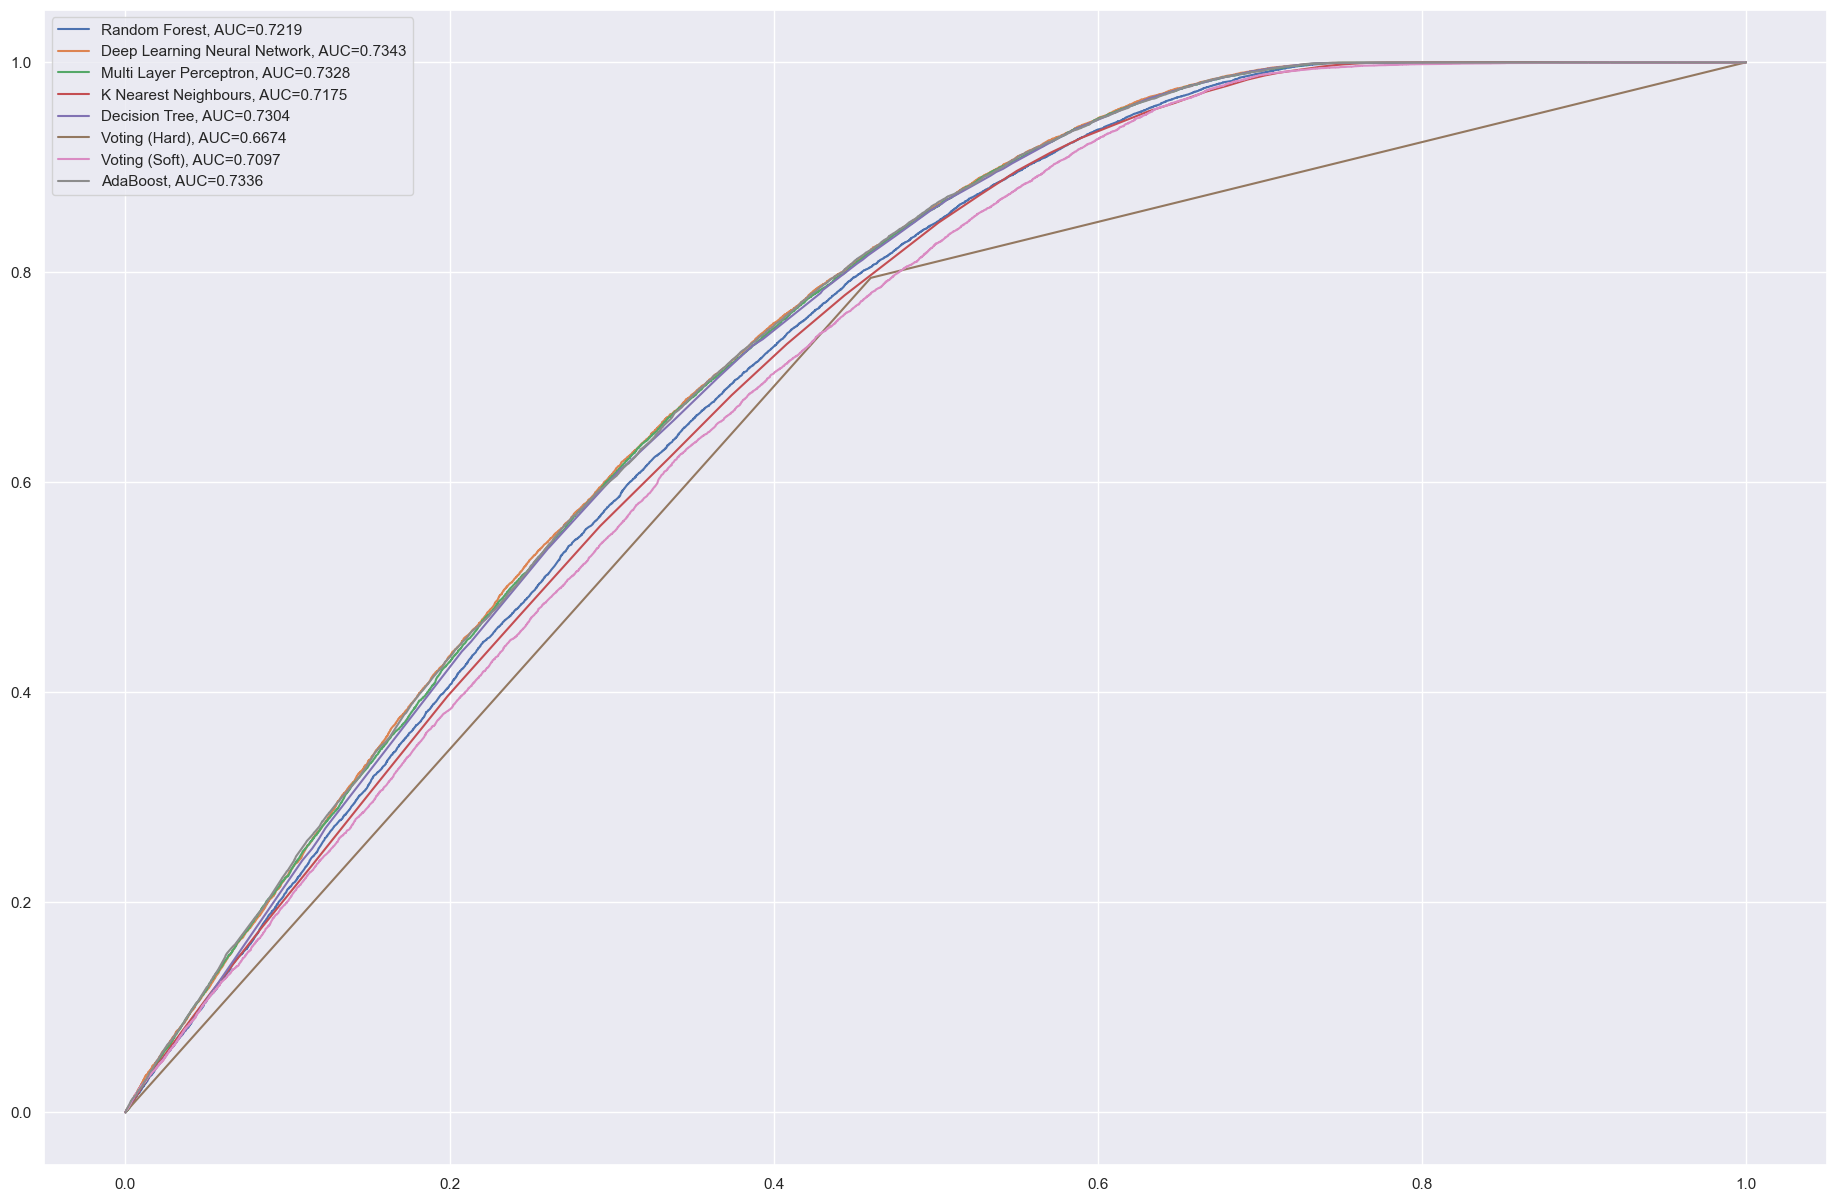

In [134]:
plt.plot(roc_df['fpr'][0], roc_df['tpr'][0],label= str(roc_df['Classifier'][0])+ ", AUC=" + str(roc_df['auc'][0]))
plt.plot(roc_df['fpr'][1], roc_df['tpr'][1],label= str(roc_df['Classifier'][1]) + ", AUC=" +str(roc_df['auc'][1]))

plt.legend()

In [135]:
classifiers_df.style.highlight_max(color = 'yellow', axis = 0)

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.673754,0.693503,0.673754,0.665212,0.721896
1,Deep Learning Neural Network,0.680959,0.640525,0.824827,0.721086,0.734198
2,Multi Layer Perceptron,0.676965,0.685075,0.676965,0.673387,0.732753
3,K Nearest Neighbours,0.669983,0.685197,0.669983,0.663063,0.717528
4,Decision Tree,0.680941,0.706790,0.680941,0.670648,0.730435
5,Voting (Hard),0.667388,0.678993,0.667388,0.661909,0.667388
6,Voting (Soft),0.659679,0.669008,0.659679,0.654917,0.709656
7,AdaBoost,0.681613,0.702693,0.681613,0.673114,0.733597
